# Week 3: Interactive LLM-Powered Chatbot

## Building a Truly Interactive Chatbot with LLM Integration

**Learning Objectives:**
- Integrate real LLM APIs (Groq) for dynamic responses
- Implement conversation memory and context management
- Add streaming responses for better UX
- Create function calling for dynamic actions
- Build personality-driven conversations
- Track costs and optimize token usage

## Setup: Install Required Libraries

In [1]:
!pip install groq transformers torch tiktoken pandas matplotlib seaborn spacy python-dotenv -q
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.8 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import os
from dotenv import load_dotenv
from groq import Groq
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch
import numpy as np
from typing import Dict, List, Optional
import spacy
import json
from datetime import datetime
import re
from IPython.display import display, Markdown, clear_output
import time

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load environment variables
load_dotenv()

# Load spaCy for entity extraction
nlp = spacy.load('en_core_web_sm')

---

## Part 1: Enhanced Intent Detection & Entity Extraction 

In [3]:
class IntentDetector:
    """Enhanced intent detection with BERT"""
    def __init__(self):
        self.intents = {
            'greeting': ['hello', 'hi', 'hey', 'good morning', 'good evening'],
            'product_inquiry': ['tell me about', 'what is', 'information about', 'details'],
            'pricing': ['how much', 'price', 'cost', 'expensive', 'cheap'],
            'complaint': ['problem', 'issue', 'not working', 'broken', 'defective'],
            'order_status': ['where is my order', 'track', 'delivery', 'shipping'],
            'return': ['return', 'refund', 'exchange', 'send back'],
            'technical_support': ['how to', 'setup', 'install', 'configure'],
            'recommendation': ['suggest', 'recommend', 'best', 'which one'],
            'goodbye': ['bye', 'goodbye', 'thanks', 'thank you']
        }
        print("Loading BERT model for intent detection...")
        self.classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
        print("✓ Intent detector ready!")
    
    def detect_intent(self, text: str) -> Dict:
        labels = list(self.intents.keys())
        result = self.classifier(text, labels, multi_label=False)
        return {
            'intent': result['labels'][0],
            'confidence': result['scores'][0],
            'all_scores': dict(zip(result['labels'][:3], result['scores'][:3]))
        }

class EntityExtractor:
    """Enhanced entity extraction with spaCy"""
    def __init__(self):
        self.nlp = nlp
        self.products = ['laptop', 'phone', 'tablet', 'headphones', 'watch', 'camera']
    
    def extract_entities(self, text: str) -> Dict:
        doc = self.nlp(text)
        entities = {
            'persons': [ent.text for ent in doc.ents if ent.label_ == 'PERSON'],
            'dates': [ent.text for ent in doc.ents if ent.label_ == 'DATE'],
            'money': [ent.text for ent in doc.ents if ent.label_ == 'MONEY'],
            'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
            'products': [p for p in self.products if p in text.lower()],
            'order_ids': re.findall(r'\b[A-Z0-9]{8,}\b', text),
            'emails': re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text),
            'phone_numbers': re.findall(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', text)
        }
        return {k: v for k, v in entities.items() if v}  # Return only non-empty

# Test the enhanced detectors
intent_detector = IntentDetector()
entity_extractor = EntityExtractor()

test_query = "I ordered a laptop on December 15th for $1200 but it's not working"
intent = intent_detector.detect_intent(test_query)
entities = entity_extractor.extract_entities(test_query)

print(f"\n📝 Query: {test_query}")
print(f"\n🎯 Intent: {intent['intent']} ({intent['confidence']:.2%} confidence)")
print(f"\n🔍 Entities: {json.dumps(entities, indent=2)}")

Loading BERT model for intent detection...


Device set to use mps:0


✓ Intent detector ready!

📝 Query: I ordered a laptop on December 15th for $1200 but it's not working

🎯 Intent: complaint (34.02% confidence)

🔍 Entities: {
  "dates": [
    "December 15th"
  ],
  "money": [
    "1200"
  ],
  "products": [
    "laptop"
  ]
}


---

## Part 2: Interactive LLM-Powered Chatbot

### Exercise 2.1: Build the Core Interactive Chatbot

In [4]:
class InteractiveLLMChatbot:
    """Advanced chatbot with LLM integration, memory, and streaming"""
    
    def __init__(self, model: str = "llama-3.3-70b-versatile", personality: str = "helpful"):
        self.client = Groq(api_key=os.getenv('GROQ_API_KEY'))
        self.model = model
        self.intent_detector = IntentDetector()
        self.entity_extractor = EntityExtractor()
        self.encoding = tiktoken.encoding_for_model('gpt-4')
        
        # Conversation state
        self.conversation_history = []
        self.context_window = []  # Last N messages for context
        self.max_context_messages = 10
        
        # Analytics
        self.total_tokens = 0
        self.total_cost = 0.0
        self.intent_stats = {}
        
        # Personality system prompts
        self.personalities = {
            'helpful': "You are a helpful, professional customer service assistant. Be concise, friendly, and solution-oriented.",
            'friendly': "You are a warm, friendly assistant who loves helping people. Use casual language and emojis occasionally.",
            'technical': "You are a technical expert assistant. Provide detailed, accurate information with technical depth.",
            'sales': "You are an enthusiastic sales assistant. Help customers find the perfect products and highlight benefits."
        }
        self.system_prompt = self.personalities.get(personality, self.personalities['helpful'])
        
        print(f"✓ Interactive LLM Chatbot initialized with {model}")
        print(f"✓ Personality: {personality}")
    
    def count_tokens(self, text: str) -> int:
        """Count tokens in text"""
        return len(self.encoding.encode(text))
    
    def build_context(self) -> List[Dict]:
        """Build conversation context for LLM"""
        messages = [{"role": "system", "content": self.system_prompt}]
        
        # Add recent conversation history
        for turn in self.context_window[-self.max_context_messages:]:
            messages.append({"role": "user", "content": turn['user']})
            messages.append({"role": "assistant", "content": turn['bot']})
        
        return messages
    
    def generate_response(self, user_message: str, stream: bool = False) -> str:
        """Generate LLM response with optional streaming"""
        messages = self.build_context()
        messages.append({"role": "user", "content": user_message})
        
        if stream:
            return self._stream_response(messages)
        else:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=0.7,
                max_tokens=500
            )
            return response.choices[0].message.content
    
    def _stream_response(self, messages: List[Dict]) -> str:
        """Stream response token by token"""
        print("🤖 Bot: ", end="", flush=True)
        full_response = ""
        
        stream = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=0.7,
            max_tokens=500,
            stream=True
        )
        
        for chunk in stream:
            if chunk.choices[0].delta.content:
                content = chunk.choices[0].delta.content
                print(content, end="", flush=True)
                full_response += content
        
        print()  # New line after streaming
        return full_response
    
    def process_message(self, user_message: str, stream: bool = False) -> Dict:
        """Process user message with intent detection, entity extraction, and LLM response"""
        # Detect intent and extract entities
        intent_result = self.intent_detector.detect_intent(user_message)
        entities = self.entity_extractor.extract_entities(user_message)
        
        # Generate LLM response
        bot_response = self.generate_response(user_message, stream=stream)
        
        # Calculate tokens and cost
        input_tokens = self.count_tokens(user_message)
        output_tokens = self.count_tokens(bot_response)
        total_tokens = input_tokens + output_tokens
        
        # Groq pricing (approximate)
        cost = (input_tokens * 0.05 + output_tokens * 0.10) / 1_000_000
        
        self.total_tokens += total_tokens
        self.total_cost += cost
        
        # Update intent statistics
        intent = intent_result['intent']
        self.intent_stats[intent] = self.intent_stats.get(intent, 0) + 1
        
        # Create conversation turn
        turn = {
            'timestamp': datetime.now().isoformat(),
            'user': user_message,
            'bot': bot_response,
            'intent': intent,
            'confidence': intent_result['confidence'],
            'entities': entities,
            'tokens': total_tokens,
            'cost': cost
        }
        
        # Update conversation history
        self.conversation_history.append(turn)
        self.context_window.append(turn)
        
        # Trim context window if needed
        if len(self.context_window) > self.max_context_messages:
            self.context_window.pop(0)
        
        return turn
    
    def chat(self, user_message: str, stream: bool = True, show_metadata: bool = True):
        """Interactive chat interface"""
        print(f"\n👤 User: {user_message}")
        
        turn = self.process_message(user_message, stream=stream)
        
        if not stream:
            print(f"🤖 Bot: {turn['bot']}")
        
        if show_metadata:
            print(f"\n📊 Metadata:")
            print(f"   Intent: {turn['intent']} ({turn['confidence']:.2%})")
            if turn['entities']:
                print(f"   Entities: {turn['entities']}")
            print(f"   Tokens: {turn['tokens']} | Cost: ${turn['cost']:.6f}")
    
    def get_analytics(self) -> Dict:
        """Get conversation analytics"""
        return {
            'total_turns': len(self.conversation_history),
            'total_tokens': self.total_tokens,
            'total_cost': self.total_cost,
            'avg_tokens_per_turn': self.total_tokens / len(self.conversation_history) if self.conversation_history else 0,
            'intent_distribution': self.intent_stats,
            'conversation_duration': self._get_duration()
        }
    
    def _get_duration(self) -> str:
        """Calculate conversation duration"""
        if len(self.conversation_history) < 2:
            return "N/A"
        start = datetime.fromisoformat(self.conversation_history[0]['timestamp'])
        end = datetime.fromisoformat(self.conversation_history[-1]['timestamp'])
        duration = end - start
        return str(duration).split('.')[0]  # Remove microseconds
    
    def export_conversation(self, filename: str = "conversation.json"):
        """Export conversation history to JSON"""
        with open(filename, 'w') as f:
            json.dump(self.conversation_history, f, indent=2)
        print(f"✓ Conversation exported to {filename}")
    
    def visualize_analytics(self):
        """Visualize conversation analytics"""
        if not self.conversation_history:
            print("No conversation data to visualize")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Intent distribution
        intent_df = pd.Series(self.intent_stats)
        intent_df.plot(kind='bar', ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('Intent Distribution', fontweight='bold')
        axes[0, 0].set_xlabel('Intent')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Token usage over time
        tokens = [turn['tokens'] for turn in self.conversation_history]
        axes[0, 1].plot(tokens, marker='o', color='green')
        axes[0, 1].set_title('Token Usage per Turn', fontweight='bold')
        axes[0, 1].set_xlabel('Turn')
        axes[0, 1].set_ylabel('Tokens')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Cost accumulation
        costs = [turn['cost'] for turn in self.conversation_history]
        cumulative_cost = np.cumsum(costs)
        axes[1, 0].plot(cumulative_cost, marker='o', color='red')
        axes[1, 0].set_title('Cumulative Cost', fontweight='bold')
        axes[1, 0].set_xlabel('Turn')
        axes[1, 0].set_ylabel('Cost ($)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Confidence distribution
        confidences = [turn['confidence'] for turn in self.conversation_history]
        axes[1, 1].hist(confidences, bins=10, color='purple', alpha=0.7)
        axes[1, 1].set_title('Intent Confidence Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Confidence')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("✓ InteractiveLLMChatbot class defined!")

✓ InteractiveLLMChatbot class defined!


### Exercise 2.2: Test the Interactive Chatbot

In [ ]:
# Create chatbot with different personalities
chatbot = InteractiveLLMChatbot(personality='helpful')

# Test conversation with streaming
# test_conversation = [
#     "Hello! I'm looking for a new laptop",
#     "I need something for video editing and gaming. Budget is around $1500",
#     "What about battery life? I travel a lot",
#     "Great! Can you help me track my order ABC12345?",
#     "Thanks for your help!"
# ]

test_conversation = input("Enter your messages separated by '|': ").split('|')

for message in test_conversation:
    chatbot.chat(message, stream=True, show_metadata=True)
    print("\n" + "="*80 + "\n")

Loading BERT model for intent detection...


Device set to use mps:0


✓ Intent detector ready!
✓ Interactive LLM Chatbot initialized with llama-3.3-70b-versatile
✓ Personality: helpful

👤 User: Hello! I'm looking for a new laptop
🤖 Bot: What's your primary use for the laptop? (e.g. work, gaming, studying, basic browsing) And what's your budget looking like?

📊 Metadata:
   Intent: greeting (67.87%)
   Entities: {'products': ['laptop']}
   Tokens: 39 | Cost: $0.000003



👤 User: I need something for video editing and gaming. Budget is around $1500
🤖 Bot: For video editing and gaming, you'll want a laptop with a strong processor, dedicated graphics, and plenty of RAM.

Here are some key specs to consider:

* Processor: Intel Core i7 or AMD Ryzen 7
* Graphics: NVIDIA GeForce GTX 1660 or higher
* RAM: 16GB or more
* Storage: 512GB or larger SSD

With your budget of $1500, here are some laptop options to consider:

* Dell XPS 15
* MSI PS65
* Razer Blade 15
* ASUS ROG Zephyrus

Would you like me to recommend a specific model or provide more details on these op

### Exercise 2.3: View Analytics and Visualizations


📊 CONVERSATION ANALYTICS
Total Turns: 5
Total Tokens: 617
Total Cost: $0.000059
Avg Tokens/Turn: 123.4
Duration: 0:00:04

Intent Distribution:
  greeting: 1
  pricing: 1
  complaint: 1
  return: 2


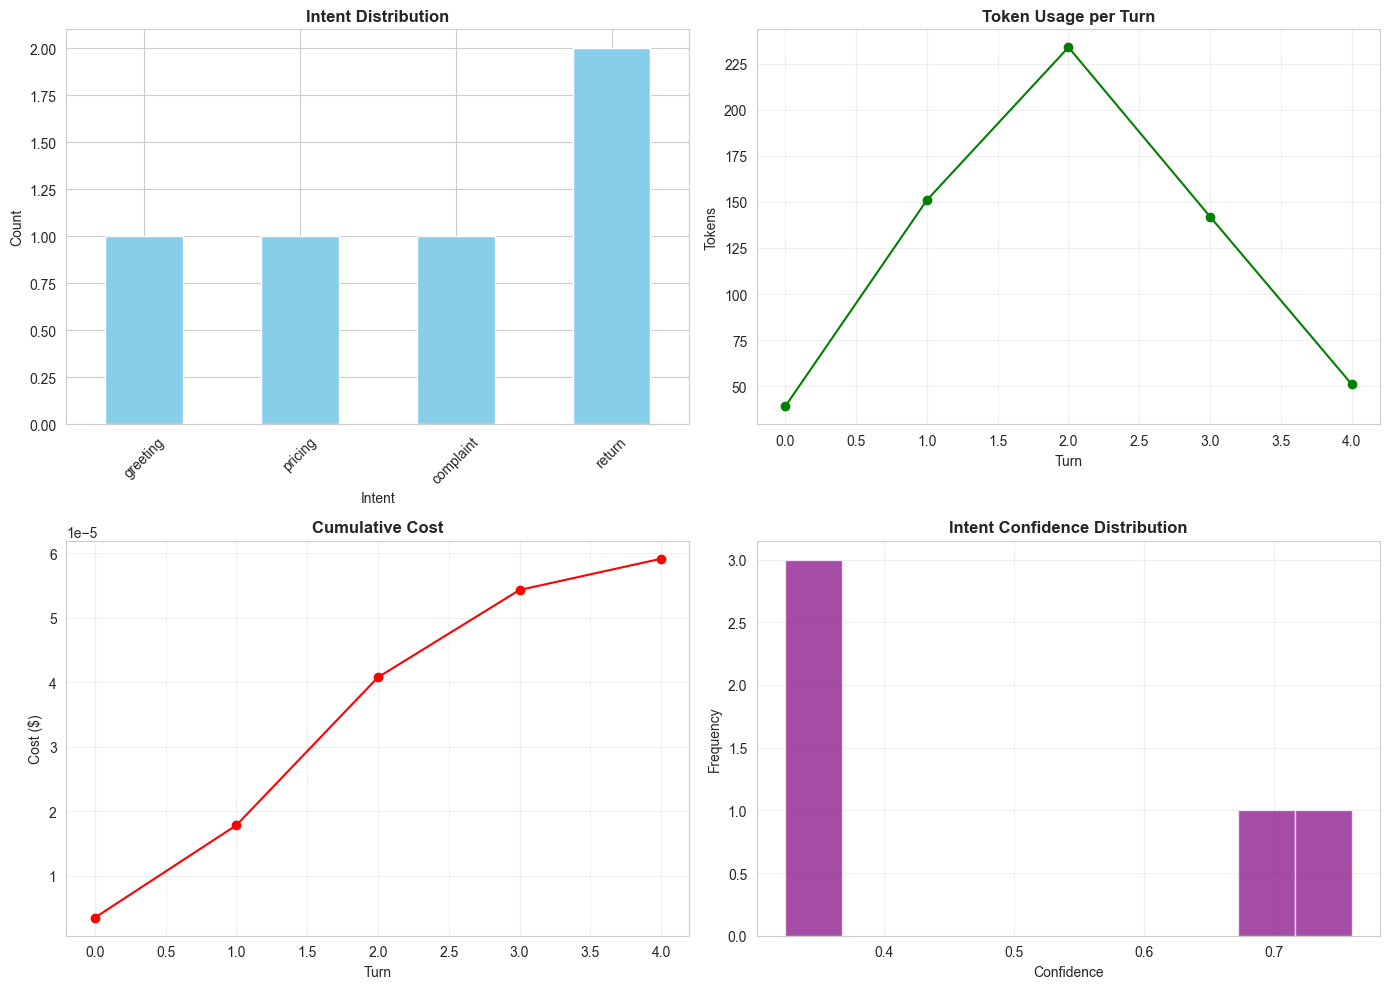

In [6]:
# Get analytics
analytics = chatbot.get_analytics()

print("\n📊 CONVERSATION ANALYTICS")
print("=" * 50)
print(f"Total Turns: {analytics['total_turns']}")
print(f"Total Tokens: {analytics['total_tokens']:,}")
print(f"Total Cost: ${analytics['total_cost']:.6f}")
print(f"Avg Tokens/Turn: {analytics['avg_tokens_per_turn']:.1f}")
print(f"Duration: {analytics['conversation_duration']}")
print(f"\nIntent Distribution:")
for intent, count in analytics['intent_distribution'].items():
    print(f"  {intent}: {count}")

# Visualize
chatbot.visualize_analytics()

### Exercise 2.4: Try Different Personalities

In [7]:
# Test different personalities
personalities = ['helpful', 'friendly', 'technical', 'sales']

test_message = "Tell me about your laptops"

for personality in personalities:
    print(f"\n{'='*80}")
    print(f"PERSONALITY: {personality.upper()}")
    print(f"{'='*80}")
    
    bot = InteractiveLLMChatbot(personality=personality)
    bot.chat(test_message, stream=False, show_metadata=False)
    print()


PERSONALITY: HELPFUL
Loading BERT model for intent detection...


Device set to use mps:0


✓ Intent detector ready!
✓ Interactive LLM Chatbot initialized with llama-3.3-70b-versatile
✓ Personality: helpful

👤 User: Tell me about your laptops
🤖 Bot: We have a wide range of laptops to suit various needs and budgets. Our laptops come with the latest processors, ample storage, and vibrant displays. We offer different models, including:

1. **Budget-friendly options**: Perfect for basic tasks like browsing, emailing, and word processing.
2. **Mid-range laptops**: Ideal for students, professionals, and gamers, offering a balance of performance and affordability.
3. **High-end laptops**: Designed for heavy users, with advanced features like 4K displays, dedicated graphics cards, and long battery life.

Some of our key features include:

* Intel Core i3, i5, and i7 processors
* Up to 16 hours of battery life
* 256GB to 1TB storage options
* 13.3" to 15.6" Full HD and 4K display options
* Windows 10 and 11 operating systems

Would you like me to recommend a specific laptop based on y

Device set to use mps:0


✓ Intent detector ready!
✓ Interactive LLM Chatbot initialized with llama-3.3-70b-versatile
✓ Personality: friendly

👤 User: Tell me about your laptops
🤖 Bot: 👋 I don't actually have laptops, since I'm a computer program running on servers. I don't have a physical body or own any devices. I exist solely to help answer your questions and provide information 🤓. But I can definitely help you learn about laptops if you're interested! What would you like to know? 📊


PERSONALITY: TECHNICAL
Loading BERT model for intent detection...


Device set to use mps:0


✓ Intent detector ready!
✓ Interactive LLM Chatbot initialized with llama-3.3-70b-versatile
✓ Personality: technical

👤 User: Tell me about your laptops
🤖 Bot: As a digital assistant, I don't have personal laptops or physical devices. I exist solely as a software program running on remote servers, designed to provide information and assist with inquiries. However, I can provide detailed information about laptops in general, including their technical specifications, features, and types.

Laptops are portable personal computers that integrate the functionality of a desktop computer into a single, compact device. They typically consist of a keyboard, touchpad, display screen, and battery, all housed in a compact chassis. Modern laptops often feature advanced technologies such as:

1. **Processors**: Central Processing Units (CPUs) from manufacturers like Intel (Core i3, i5, i7) or AMD (Ryzen 3, 5, 7), which execute instructions and handle computations.
2. **Memory and Storage**: Laptops o

Device set to use mps:0


✓ Intent detector ready!
✓ Interactive LLM Chatbot initialized with llama-3.3-70b-versatile
✓ Personality: sales

👤 User: Tell me about your laptops
🤖 Bot: WE'VE GOT SOME AMAZING LAPTOPS IN STOCK RIGHT NOW! We've got a wide range of options to suit every need and budget, from basic browsing and emailing to high-performance gaming and video editing.

Let me show you some of our most popular models. We've got the latest Intel Core i5 and i7 processors, along with plenty of RAM and storage to ensure you can multitask with ease. Our laptops also feature stunning displays, with options for 4K, touchscreens, and even OLED panels.

For students and professionals, we recommend our Ultrabook series. These laptops are super slim and lightweight, making them perfect for taking on the go. They're also packed with features like long battery life, backlit keyboards, and fingerprint readers for added security.

If you're a gamer, you'll love our Gaming Laptop series. These beasts are equipped with NV

---

## Part 3: Interactive Chat Loop

In [8]:
# Interactive chat loop - uncomment to use
chatbot = InteractiveLLMChatbot(personality='friendly')

print("\n🤖 Interactive Chatbot Started!")
print("Type 'quit' to exit, 'export' to save conversation, 'analytics' to view stats\n")

while True:
    user_input = input("You: ").strip()
    
    if user_input.lower() == 'quit':
        print("\n👋 Goodbye!")
        break
    elif user_input.lower() == 'export':
        chatbot.export_conversation()
        continue
    elif user_input.lower() == 'analytics':
        analytics = chatbot.get_analytics()
        print(json.dumps(analytics, indent=2))
        continue
    elif not user_input:
        continue
    
    chatbot.chat(user_input, stream=True, show_metadata=True)

Loading BERT model for intent detection...


Device set to use mps:0


✓ Intent detector ready!
✓ Interactive LLM Chatbot initialized with llama-3.3-70b-versatile
✓ Personality: friendly

🤖 Interactive Chatbot Started!
Type 'quit' to exit, 'export' to save conversation, 'analytics' to view stats


👤 User: hi
🤖 Bot: 😊 Hi there! It's nice to meet you. Is there something I can help you with, or do you just want to chat? 😊

📊 Metadata:
   Intent: return (27.46%)
   Tokens: 32 | Cost: $0.000003

👤 User: tell me about hyderabad
🤖 Bot: Hyderabad 🏙️! It's a city located in the southern part of India, and it's a total gem 💎. Hyderabad is the capital of the state of Telangana, and it's known for its rich history, cultural heritage, and delicious food 🍴.

The city has a unique blend of traditional and modern architecture, with ancient mosques, temples, and palaces standing alongside modern skyscrapers and IT parks 🌆. Some of the must-visit places in Hyderabad include the Charminar 🕊️, a iconic mosque and landmark, the Golconda Fort 🏰, a historic fort that's said to 